1. 데이터를 class별로 다른 폴더에 저장
<br> --> 그래야지 클래스별로 몇개씩인지 등 알기 쉬움
2. oversampling한 다음에 1처럼

---

In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
from multiprocessing.dummy import Pool

import numpy as np
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
import random
import matplotlib.pyplot as plt

In [1]:
!rm -r "data/0203" "data/0203_oversampling"

---

# 1. 데이터를 class별로 다른 폴더에 저장

In [4]:
data = np.load("data/0203.npz")

In [5]:
X_train, Y_train, X_test = data["X_train"], data["Y_train"], data["X_test"]

In [6]:
out_dir = Path("data/0203")
out_dir.mkdir(parents=True, exist_ok=True)

train_dir = out_dir / "train"
test_dir = out_dir / "test"
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

In [7]:
nums_per_label = {}
with tqdm(total=len(X_train), ncols=100) as t:
    for i, (x, y) in enumerate(zip(X_train, Y_train)):
        y_ = int(y)
        if y_ not in nums_per_label:
            nums_per_label[y_] = 0
            (train_dir / f"{y_:02d}").mkdir(exist_ok=True)

        fpath = train_dir / f"{y_:02d}" / f"{i:05d}.npz"
        np.savez_compressed(fpath, x=x, y=y)

        nums_per_label[y_] += 1
        t.update()

100%|██████████████████████████████████████████████████████████| 3125/3125 [00:10<00:00, 301.30it/s]


In [8]:
with tqdm(total=len(X_test), ncols=100) as t:
    for i, x in enumerate(X_test):
        fpath = test_dir / f"{i:05d}.npz"
        np.savez_compressed(fpath, x=x)
        t.update()

100%|████████████████████████████████████████████████████████████| 782/782 [00:02<00:00, 317.05it/s]


# 2. oversampling한 다음에 1처럼

In [9]:
aug_dir = out_dir / "train_aug"
aug_dir.mkdir(parents=True, exist_ok=True)

In [16]:
for i in range(61):
    (aug_dir / f"{i:02d}").mkdir(parents=True, exist_ok=True)

In [17]:
def random_shift(x):
    shift = random.randint(0, 600)
    x = np.roll(x, shift, axis=1)
    return x

In [11]:
# TODO: sin/cow파 등 시작과 끝이 일치하는 파형을 곱해주는 방식

In [18]:
n_max = 1518
repeat_per_label = {}
for label, n in nums_per_label.items():
    repeat_per_label[label] = int((n_max - n) / n)

In [19]:
with tqdm(total=len(X_train), ncols=100) as t:
    for i, (x, y) in enumerate(zip(X_train, Y_train)):
        y_ = int(y)
        for j in range(repeat_per_label[y_]):
            fpath = aug_dir / f"{y_:02d}" / f"{i:05d}_{j:04d}.npz"
            x_ = random_shift(x)
            np.savez_compressed(fpath, x=x_, y=y)
        t.update()

100%|███████████████████████████████████████████████████████████| 3125/3125 [04:57<00:00, 10.51it/s]


```
data/0203
  - test
    - 00000.npz
    - ...
  - train
    - 00
    - 01
      - 00001.npz
    - ...
  - train_aug
    - 00
    - 01
      - 00002_0001.npz
      - ...
    - ...
```

test와 train 폴더는 원본 데이터  
train_aug는 augmentation된 데이터를 모아둠

## 각 class별 개수 확인

In [22]:
l = [len(list((train_dir / f"{i:02d}").glob("*.npz"))) for i in range(61)]

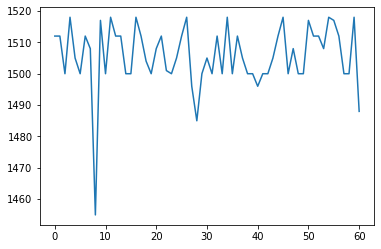

In [28]:
plt.plot(l)